Establish the Auto-Reload Parameters for this notebook

In [1]:
cd /Users/mouawad/Research/Comet_Example_Data

/Users/mouawad/Research/Comet_Example_Data


In [2]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let matplotlib plot images inline

In [3]:
%matplotlib inline

Load the `pandas` library for data analysis tools -- to be used after image subtraction

In [4]:
import pandas as pd

Load necessary features, functions, and classes from established libraries

In [5]:
from astropy.wcs        import WCS
from astropy.io         import fits
from astropy.io.ascii   import read as asciiRead
from astropy.modeling   import models, fitting
from astropy.stats      import sigma_clipped_stats
from astropy.table      import Table

from glob           import glob

from image_registration import chi2_shift, fft_tools

from matplotlib         import rcParams
from matplotlib.colors  import LogNorm
from matplotlib         import style

from os                 import system

from photutils  import aperture_photometry, CircularAperture, DAOStarFinder

from pylab      import *

from numpy          import nansum, argmin

from reproject  import reproject_exact

from subprocess               import call
from statsmodels.robust.scale import mad

from time import time
from tqdm import tqdm_notebook

Set up the matplotlib plotting features

In [6]:
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"]  = 100
rcParams["axes.grid"]   = False

Establish the default coordinate system

In [7]:
y,x = 0,1

# Load Fits Files and Comet Data

Comet data table -- location of the comet in the frame

In [8]:
comet_dat = asciiRead('comet74p.dat')
yc,xc,zc  = comet_dat['Y_PIXEL'].data[0], comet_dat['X_PIXEL'].data[0], 0.0

# Store this in case we shrink the image for analysis later
yc_0, xc_0= np.copy(yc), np.copy(xc)

Store the Reference image file name in `ref_image_name`

In [9]:
ref_image_name  = 'PTF_d100124_f02_c00_u000098496_p12_refimg.fits'

Store the Comet (science) image file name in `sci_image_name`

In [10]:
sci_image_name  = 'PTF_201002173554_i_p_scie_t083147_u011673859_f02_p100124_c00.fits'

Store the Astronmetry.net output (for command line) file name in `adn_ref_image_name` and `adn_sci_image_name`

In [11]:
# adn == AstrometryDotNet
adn_ref_image_name  = 'adn_new_local_PTF_d100124_f02_c00_u000098496_p12_refimg.fits'
adn_sci_image_name  = 'adn_new_local_PTF_201002173554_i_p_scie_t083147_u011673859_f02_p100124_c00.fits'

Store the newly Reprojected Reference output file name in `refproj_image_name`

In [12]:
refproj_im_name = 'adn_refproj_loc_PTF_d100124_f02_c00_u000098496_p12_refimg.fits'# refproj == reference reprojected

Store the HOTPANTS output (for command line) file name in `hotpants_im_name`

In [13]:
hotpants_im_name= 'science_minus_reference_u000098496_m_u011673859.fits' # hotpants == image subtract algorithm

Load the raw reference image as `ref_frame_0`. The zero (_0) symbolizes that this is the 'original' data, which we will manipulate here

In [14]:
ref_frame_0  = fits.open(ref_image_name) # load reference frame

Load the raw science image as `sci_frame`. The zero (_0) symbolizes that this is the 'original' data, which we will manipulate here (only with astronmetry.net for new WCS coordinates)

In [15]:
sci_frame_0  = fits.open(sci_image_name) # load science   frame

Print out the Science Frame Header of useful information -- at least as a sanity check

In [16]:
sci_frame_0[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / FOUR-BYTE SINGLE PRECISION FLOATING POINT      
NAXIS   =                    2 / STANDARD FITS FORMAT                           
NAXIS1  =                 2048 / STANDARD FITS FORMAT                           
NAXIS2  =                 4096 / STANDARD FITS FORMAT                           
ORIGIN  = 'Palomar Transient Factory' / Origin of these image data              
CREATOR = 'Infrared Processing and Analysis Center' / Creator of this FITS file 
TELESCOP= 'P48     '           / Name of telescope                              
INSTRUME= 'PTF/MOSAIC'         / Instrument name                                
OBSERVER= 'KulkarniPTF'        / Observer name and project                      
CCDID   = '0       '           / CCD number (0..11)                             
DATE-OBS= '2010-02-17T08:31:47.904' / UTC shutter time YYYY-MM-DDTHH:MM:SS.SSS  
DATE    = '2011-06-18T04:20:

Print out the Reference Frame Header of useful information -- at least as a sanity check

In [17]:
ref_frame_0[1].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
OSIMPLE =                    T / Fits standard                                  
OBITPIX =                  -32 / FOUR-BYTE SINGLE PRECISION FLOATING POINT      
ONAXIS  =                    2 / STANDARD FITS FORMAT                           
ONAXIS1 =                 2048 / STANDARD FITS FORMAT                           
ONAXIS2 =                 4096 / STANDARD FITS FORMAT                           
ORIGIN  = 'Palomar Transient Factory' / Origin of these image data              
CREATOR = 'Infrared Processing and Analysis Center' / Creator of this FITS file 
TELESCOP= 'P48     '        

Print out the Comet Data table of useful information -- at least as a sanity check. Note that we will be changing the WCS coordinates for both the reference and science fits files. The `X_PIXEL` and `Y_PIXEL` values will stay the same, but the  `R.A.` and `Dec.` will change slightly

In [18]:
comet_dat

comet name,mag,magerr,FWHM,FWHMerr,X_PIXEL,Y_PIXEL,R.A.(deg),Dec.(deg)
str21,float64,float64,float64,float64,float64,float64,float64,float64
74P/Smirnova-Chernykh,16.36,0.02,25.0,3.5,911.9,3782.1,210.164279,-4.899413


# Manipulate the Reference file/image to subtract from the Science image

1. Reconfigure WCS for reference frame
2. Reconfigure WCS for science frame
3. Reproject reference frame image to science frame header (WCS)
4. Register the reference frame image to the science frame inmage
    - this step corrects for small errors in WCS reprojection
5. Subtract the newly re-oriented reference frame from the science frame

**Astronometry.net**

Use Astronomety.net to reconfigure the reference frame WCS coordinates to updated values

http://astrometry.net

http://astrometry.net/doc/readme.html

In [20]:
adn_ref_command = 'solve-field -N {} {}'.format(adn_ref_image_name, ref_image_name)
print('Running: ' + adn_ref_command)
call(['solve-field','-N', adn_ref_image_name, ref_image_name])

print('Newly WCS coordinated reference file (from astrometry.net) stored in ' + adn_sci_image_name)

Running: solve-field -N adn_new_local_PTF_d100124_f02_c00_u000098496_p12_refimg.fits PTF_d100124_f02_c00_u000098496_p12_refimg.fits
Newly WCS coordinated reference file (from astrometry.net) stored in adn_new_local_PTF_201002173554_i_p_scie_t083147_u011673859_f02_p100124_c00.fits


Use Astronomety.net to reconfigure the science frame WCS coordinates to updated values

In [21]:
adn_sci_command = 'solve-field -N {} {}'.format(adn_sci_image_name, sci_image_name)
print('Running: ' + adn_sci_command)
call(['solve-field','-N', adn_sci_image_name, sci_image_name])

print('Newly WCS coordinated science file (from astrometry.net) stored in ' + adn_sci_image_name)

Running: solve-field -N adn_new_local_PTF_201002173554_i_p_scie_t083147_u011673859_f02_p100124_c00.fits PTF_201002173554_i_p_scie_t083147_u011673859_f02_p100124_c00.fits
Newly WCS coordinated science file (from astrometry.net) stored in adn_new_local_PTF_201002173554_i_p_scie_t083147_u011673859_f02_p100124_c00.fits


Load newly Astronmety.net processed Reference fits file

In [22]:
ref_frame_adn = fits.open(adn_ref_image_name)

Load newly Astronmety.net processed Science fits file

In [23]:
sci_frame_adn = fits.open(adn_sci_image_name)

**Reproject the Reference Frame into the Science Frame WCS coordinates**

In [25]:
refproj_out     = reproject_exact(ref_frame_adn[0], sci_frame_adn[0].header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


**Image Registration**

Register (i.e. interpolate) the reference frame into the science frame pixel coordiantes

In [26]:
# Determine the magnitude of the shfit in X and Y pixel coordinates
xshift, yshift, xshifterr, yshifterr  = chi2_shift(refproj_out[0], sci_frame_adn[0].data)

# Perform the shift in X and Y pixel coordinates
refproj_imReg_out = fft_tools.shift2d(refproj_out[0], xshift, yshift)

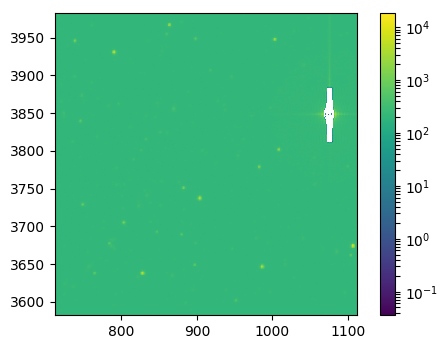

In [27]:
imshow(refproj_imReg_out - np.median(refproj_imReg_out) + 2*np.std(refproj_imReg_out), norm=LogNorm())

sub_image_half = 200 # pixels
xlim(xc_0 - sub_image_half, xc_0 + sub_image_half) # we transposed the image, so the x location goes with `ylim`
ylim(yc_0 - sub_image_half, yc_0 + sub_image_half) # we transposed the image, so the y location goes with `xlim`

colorbar();

Save the repojected and registered reference file into a new fits file

In [28]:
fits.writeto(refproj_im_name, refproj_imReg_out, header=sci_frame_adn[0].header, overwrite=True)
print('Reproject and Registered Reference file stored in ' + refproj_im_name)

Reproject and Registered Reference file stored in adn_refproj_loc_PTF_d100124_f02_c00_u000098496_p12_refimg.fits


**HOTPANTS: High Order Transform of PSF ANd Template Subtraction**

Transform the reference image into the science image using both a PSF Shape and Flux transformation algorithm `HOTPANTS`

https://github.com/acbecker/hotpants

```bash
hotpants -inim   PTF_201002173554_i_p_scie_t083147_u011673859_f02_p100124_c00.fits         \
         -tmplim asm_reproj_loc_PTF_d100124_f02_c00_u000098496_p12_refimg.fits             \
         -outim  manual_science_minus_reference_default_ng888.fits   \
         -c i -n i -sconv -ko 3 -bgo 2                                                     \
         -ssf   PTF_201002173554_i_p_scie_t083147_u011673859_f02_p100124_c00.substamps.dat \
         -nss 1 -afssc 25                                                                  \
         -ng 3 8 0.7 8 1.5 8 3.0

```

In [29]:
control_parameters    = False # These don't seem to be making the image any better
specify_stars_to_psf  = False # These don't seem to be making the image any better
ng_manual             = False # These don't seem to be making the image any better

In [30]:
# hp_command = 'hotpants -inim {} -tmplim {} -outim {}'.format(adn_sci_image_name, refproj_im_name, hotpants_im_name)

hp_call = ['hotpants', '-inim', adn_sci_image_name, '-tmplim', refproj_im_name, '-outim', hotpants_im_name]

if control_parameters:
    hp_call.extend(['-c', 'i', '-n', 'i', '-sconv', '-ko', '3', '-bgo', '2'])

if specify_stars_to_psf:
    star_substamp_XY_fname = 'PTF_201002173554_i_p_scie_t083147_u011673859_f02_p100124_c00.substamps.dat'
    hp_call.extend(['-ssf', star_substamp_XY_fname])
    hp_call.extend(['-nss', '1', '-afssc', '25'])

if ng_manual:
    # hp_call.extend(['-ng', '4', '6', '0.7', '4', '1.5', '2', '3.0', '2', '6.0'])
    hp_call.extend(['-ng', '3', '6', '0.7', '4', '1.5', '2', '3.0']) # Default

hp_command = ''
for hp_part in hp_call:
    hp_command = hp_command + hp_part + ' '

print('Running:\n' + hp_command)

call(hp_call)

print('Subtracted file stored in ' + hotpants_im_name)

Running:
hotpants -inim adn_new_local_PTF_201002173554_i_p_scie_t083147_u011673859_f02_p100124_c00.fits -tmplim adn_refproj_loc_PTF_d100124_f02_c00_u000098496_p12_refimg.fits -outim science_minus_reference_u000098496_m_u011673859.fits 
Subtracted file stored in science_minus_reference_u000098496_m_u011673859.fits


Load the newly subtracted image in DS9

In [56]:
call(['open', '-a', 'SAOImageDS9', hotpants_im_name])

0

Load the newly subtracted image here (Jupyter Notebook)

In [33]:
hp_subtracted_image = fits.open(hotpants_im_name)

View the location near the comet.  Note that this image is the transpose to fit on canonical screen aspect ratios

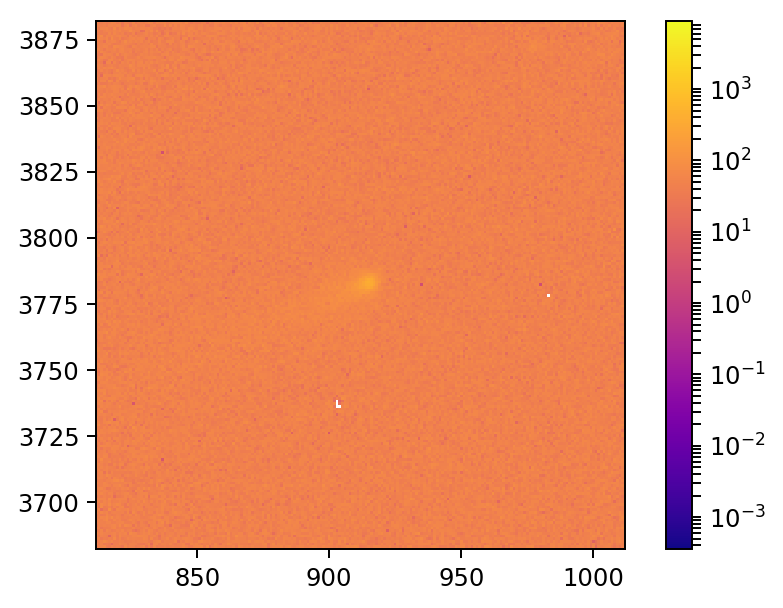

In [34]:
%matplotlib inline
rcParams["savefig.dpi"] = 175
rcParams["figure.dpi"]  = 175

imshow(hp_subtracted_image[0].data + 2*std(hp_subtracted_image[0].data), norm=LogNorm(), cmap=cm.plasma)

sub_image_half = 100 # pixels
xlim(xc_0 - sub_image_half, xc_0 + sub_image_half) # we transposed the image, so the x location goes with `ylim`
ylim(yc_0 - sub_image_half, yc_0 + sub_image_half) # we transposed the image, so the y location goes with `xlim`

colorbar();

# Measure Subtraction Statistics

Using DAOFind and Photutils -- both from astropy -- we can measure how well the subtraction worked

In [35]:
sigma = 3.0
iters = 5

Compute Statistics for Reprojected Reference Image

In [36]:
ref_mean, ref_median, ref_std = sigma_clipped_stats(refproj_imReg_out, sigma=sigma, iters=iters)

Compute Statistics for Science Image

In [37]:
sci_mean, sci_median, sci_std = sigma_clipped_stats(sci_frame_adn[0].data, sigma=sigma, iters=iters)

Compute Statistics for Subtracted Image: 'hps' == HotPants Subtracted

In [38]:
hps_mean, hps_median, hps_std = sigma_clipped_stats(hp_subtracted_image[0].data, sigma=sigma, iters=iters)

Print out the above statistics -- sanity check that nothing is too far off

In [39]:
print(ref_mean, ref_median, ref_std)

334.7724916530243 334.67674985055 3.0292547151763403


In [40]:
print(sci_mean, sci_median, sci_std)

1331.3609692212356 1331.2593994140625 30.456614232766515


The values for the subtracted image should all be close to zero -- at minimum, much closer than the raw images

In [41]:
print(hps_mean, hps_median, hps_std)

0.06279308615610468 1.0000000031710769e-30 11.498429324383322


Set up DAOFind for source identification

In [42]:
nSig  = 5.0
fwhm  = 3.0

Use DAOFind to find all of the sources in the reference image

In [43]:
ref_daofind     = DAOStarFinder(fwhm=fwhm, threshold=nSig*ref_std)
ref_dao_sources = ref_daofind(refproj_imReg_out - ref_median)

In [44]:
print('Found {} sources in the reference frame\n\n'.format(len(ref_dao_sources)))
print(ref_dao_sources)

Found 7471 sources in the reference frame


 id      xcentroid      ...        flux                 mag         
---- ------------------ ... ------------------ ---------------------
   1 221.01038126740755 ... 17.792427151899577     -3.12558799089223
   2   720.140514071159 ...  2.505131661831818   -0.9970763898838189
   3   961.362298477902 ... 1.3325924168030565  -0.31174334390098624
   4 1346.2848922322923 ...   1.71334060086696   -0.5846092661020543
   5  139.4334400118871 ... 1.1455894366675228  -0.14757250102206407
   6  745.5222374560232 ... 1.0339882120505275  -0.03628896906456078
   7 1103.9501313008352 ... 2.1432117673582547   -0.8276627127787579
   8 1728.9169783541522 ... 1.0163119122803148 -0.017567540029768527
   9 413.49545504462463 ...  3.114440573022124    -1.233450121172938
  10  949.2555926776557 ... 1.6300990119360972   -0.5305349604447819
 ...                ... ...                ...                   ...
7461 14.662877594207819 ... 15.871223731204676    -3.001526

Use DAOFind to find all of the sources in the science image

In [45]:
sci_daofind = DAOStarFinder(fwhm=fwhm, threshold=nSig*sci_std)
sci_dao_sources = sci_daofind(sci_frame_adn[0].data - sci_median)

In [46]:
print('Found {} sources in the science frame\n\n'.format(len(sci_dao_sources)))
print(sci_dao_sources)

Found 1939 sources in the science frame


 id      xcentroid      ...        flux                mag         
---- ------------------ ... ------------------ --------------------
   1  84.32507514094027 ... 2.8466888554343353   -1.135850002823066
   2  92.75768962912889 ... 2.5581158735482266   -1.019800531457882
   3  475.3325185950535 ...  2.599996865809087   -1.037432061116815
   4   84.1194641244433 ... 1.7620634604627974  -0.6150538635279158
   5 1919.4748513990276 ... 202.29480547752073   -5.764961827769661
   6  941.8143158177106 ... 1.3772107238896443  -0.3475009893873632
   7 1855.7899692143321 ... 2.7548552670895874  -1.1002469677195308
   8 277.36248923391116 ... 2.4215131644337857   -0.960217086022377
   9  859.4731067430565 ... 1.0997436158709828 -0.10322862382604428
  10 1185.9151290786515 ...  147.4290087989446   -5.421457364197196
 ...                ... ...                ...                  ...
1929 406.75785530958314 ...  152.6695391563676   -5.459380986617019
1930 1

Use DAOFind to find all of the sources in the hotpants subtracted image

In [47]:
hps_daofind = DAOStarFinder(fwhm=fwhm, threshold=nSig*hps_std)
hps_dao_sources = hps_daofind(hp_subtracted_image[0].data - hps_median)

In the best case scenario, `DAOStarFinder` will only be able to find one source, which is the comet

In [48]:
print('Found {} sources in the subtracted frame\n\n'.format(len(hps_dao_sources)))
print(hps_dao_sources)

Found 405 sources in the subtracted frame


 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  81.13364580340638 ...  1.468280950457426 -0.41702291067868547
  2  725.1203055002427 ... 1.7132231392284163  -0.5845348286402936
  3  1070.989310534551 ... 1.1182447014149544 -0.12134212257406832
  4 1074.1837419761878 ... 1.3744746574593663  -0.3453418418473733
  5 1085.6557085252184 ... 25.376478529370438  -3.5110783882332686
  6 1369.6995071425456 ... 3.3677504074604427   -1.318349743381878
  7 1371.9490395001885 ...  2.069009369225074  -0.7894061432829159
  8  552.9397190541014 ...   48.4706224023344   -4.213696491135033
  9 1078.6168049210412 ... 22.318504008459428     -3.3716627020701
 10  637.9683902404862 ... 1.8925617019565923  -0.6926251185576819
...                ... ...                ...                  ...
395  460.9799004019918 ... 4.7799056071087636  -1.6985483007789546
396 1539.112360110

**Plot Star Fields and Sources Found**

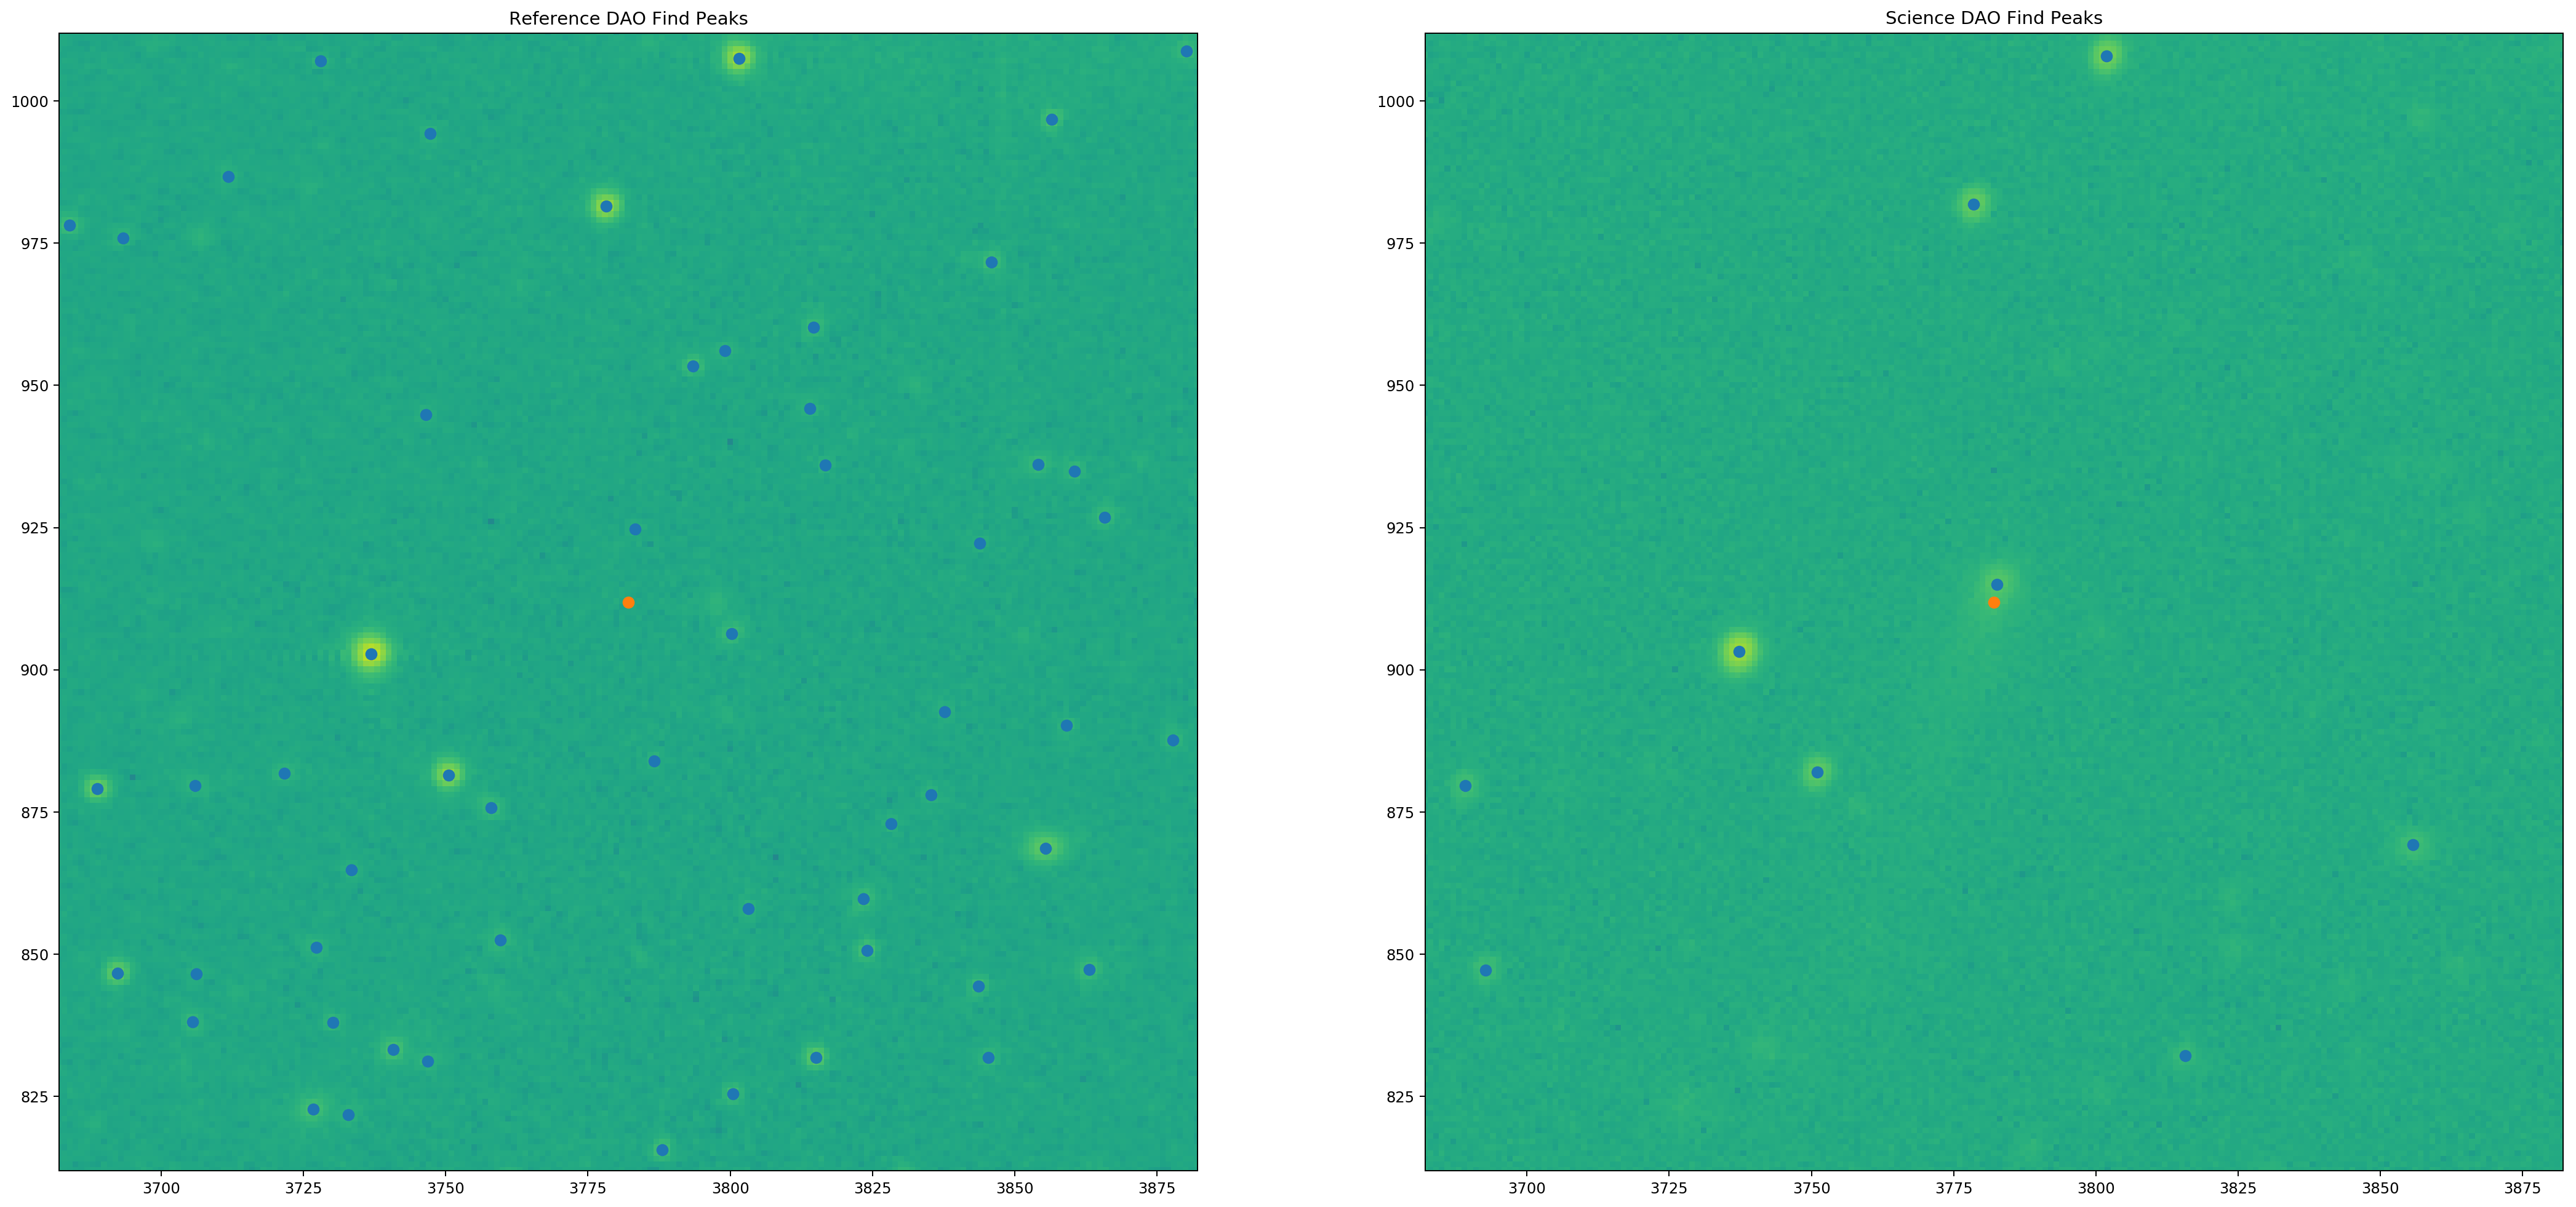

In [49]:
nSig= 5   # Number of sigma
bw  = 100 # box-width

fig = figure(figsize=(30,15));
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(refproj_imReg_out.T - ref_median + nSig*ref_std, norm=LogNorm());
ax1.scatter(ref_dao_sources['ycentroid'] , ref_dao_sources['xcentroid'], s=50);#, alpha=0.5);
ax1.scatter(yc_0, xc_0, s=50)
ax1.set_xlim(yc_0-bw, yc_0+bw);
ax1.set_ylim(xc_0-bw, xc_0+bw);

ax2.imshow(sci_frame_adn[0].data.T - sci_median + 5*sci_std, norm=LogNorm());
ax2.scatter(sci_dao_sources['ycentroid'] , sci_dao_sources['xcentroid'], s=50);#, alpha=0.5);
ax2.scatter(yc_0, xc_0, s=50);
ax2.set_xlim(yc_0-bw, yc_0+bw);
ax2.set_ylim(xc_0-bw, xc_0+bw);

ax1.set_title('Reference DAO Find Peaks');
ax2.set_title('Science DAO Find Peaks');

Show the subtracted image with the known sources

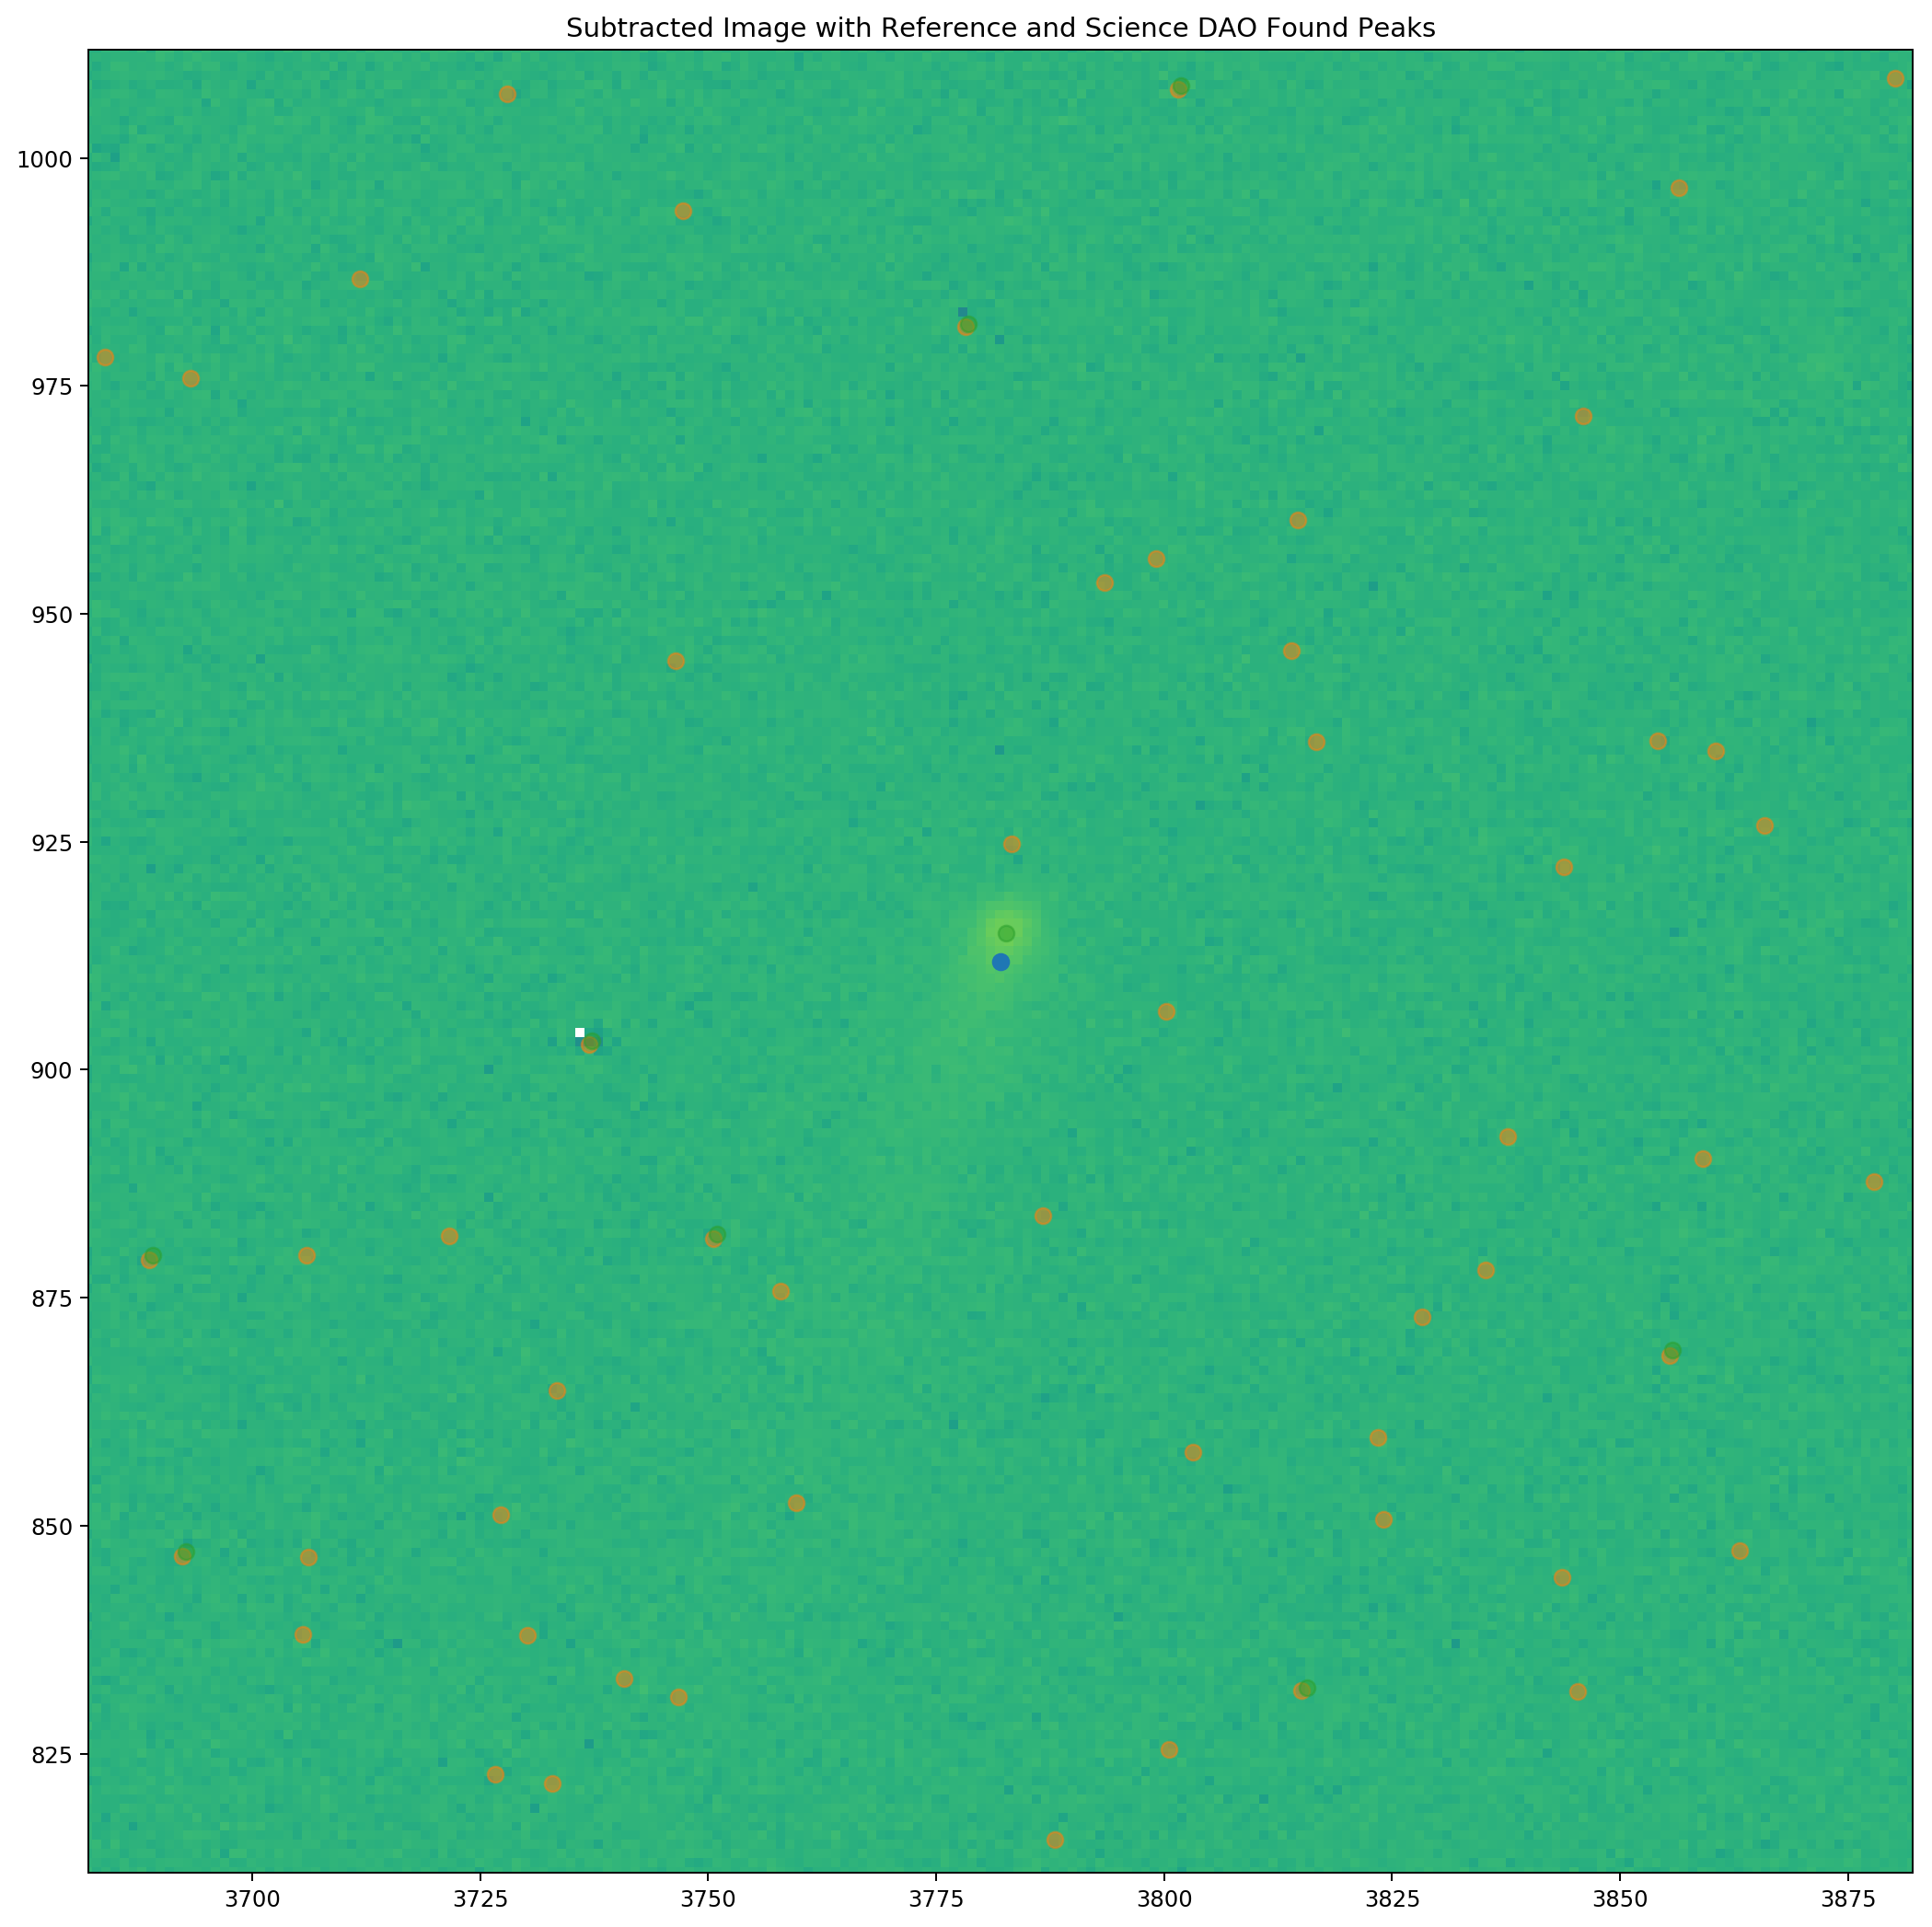

In [50]:
nSig= 5   # Number of sigma
bw  = 100 # box-width

fig = figure(figsize=(15,15));
ax1 = fig.add_subplot(111)

ax1.imshow(hp_subtracted_image[0].data.T - hps_median + nSig*hps_std, norm=LogNorm());
ax1.scatter( yc_0   , xc_0   , s=50)
ax1.scatter(ref_dao_sources['ycentroid'] , ref_dao_sources['xcentroid'], s=50, alpha=0.5);
ax1.scatter(sci_dao_sources['ycentroid'] , sci_dao_sources['xcentroid'], s=50, alpha=0.5);
ax1.set_xlim(yc_0-bw, yc_0+bw);
ax1.set_ylim(xc_0-bw, xc_0+bw);

ax1.set_title('Subtracted Image with Reference and Science DAO Found Peaks');

In [51]:
from photutils.utils import calc_total_error

In [122]:
def check_rmse_subtracted_image(subtracted_image, sources, aperRad = 4.0, ycomet=None, xcomet=None, subarray_size=50):
    if ycomet is not None and xcomet is not None:
        idx_comet = abs(sqrt((sources['xcentroid'].data - xcomet)**2 + (sources['ycentroid'].data - ycomet)**2)).argmin()
        
        xcomet    = sources['xcentroid'].data [idx_comet]
        ycomet    = sources['ycentroid'].data [idx_comet]
        
        positions = []
        for pos in zip(sources['xcentroid'].data, sources['ycentroid'].data):
            if sqrt((pos[0] - xcomet)**2 + (pos[1] - ycomet)**2) < subarray_size:
                if pos[0] is not xcomet and pos[1] is not ycomet:
                    positions.append(pos)
    else:
        positions = (sources['xcentroid'], sources['ycentroid'])
    
    apertures                 = CircularAperture(positions, r=aperRad)
    subtracted_aperture_phot  = aperture_photometry(subtracted_image, apertures)
    
    return nansum((subtracted_aperture_phot['aperture_sum'].data)**2), positions

In [136]:
aperRads     = np.arange(1.0,10.0, 0.5)
rmse_aperRad = np.zeros(len(aperRads))
for krad, aperRad in enumerate(aperRads):
    rmse_aperRad[krad], positions = check_rmse_subtracted_image(hp_subtracted_image[0].data, ref_dao_sources, 
                                                                    aperRad=aperRad, ycomet=yc_0, xcomet=xc_0,
                                                                    subarray_size = 100)

In [124]:
color_cycle = rcParams['axes.prop_cycle'].by_key()['color']

In [125]:
sum(hp_subtracted_image[0].data), median(hp_subtracted_image[0].data)

(-685253.9, 1e-30)

Text(0.5,0,'Aperture Radii for Subtracted Photometry')

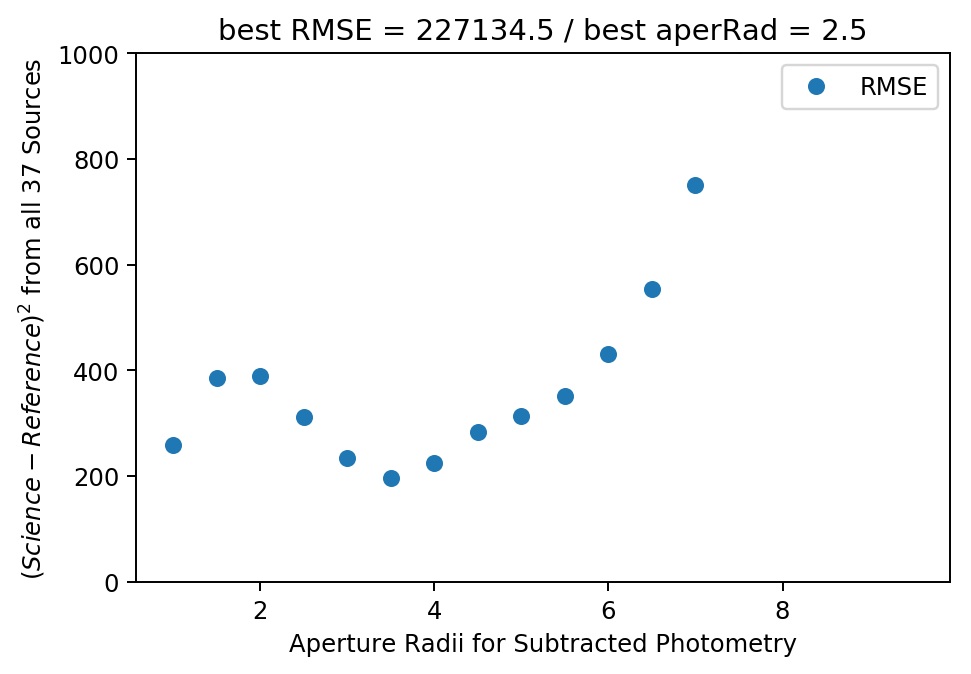

In [137]:
where_best   = np.where(rmse_aperRad == rmse_aperRad[aperRads > 2.0].min())[0][0]
best_aperRad = aperRads[where_best]
best_rmse    = rmse_aperRad[where_best]
  
sig2FHWM      = 2*sqrt(2*log(2))
n_ref_sources = len(positions)

plot(aperRads, rmse_aperRad / (n_ref_sources*pi*aperRads**2), 'o', label='RMSE', color=color_cycle[0]);
# axvline(hp_subtracted_image[0].header['FWHMSEX'] / sig2FHWM, label='FWHM Extractor', color=color_cycle[1]);
# axvline(best_aperRad, label='Best FWHM RMSE', color=color_cycle[2]);

legend(loc=0);
title('best RMSE = {} / best aperRad = {}'.format(np.round(best_rmse,1), best_aperRad));
ylim(0,1000)
# ylim(0,10*best_rmse/ (n_ref_sources*pi*best_aperRad**2))
# xlim(0, max(aperRads[rmse_aperRad < 3*best_rmse]))

ylabel('$(Science-Reference)^2$ from all {} Sources'.format(len(positions)))
xlabel('Aperture Radii for Subtracted Photometry')

**End Peak Finder Test**

# Older functions that may still be useful

In [ ]:
def gaussian1D(center, width, height = None, offset = None):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """    
    """
        Written by Nate Lust
        Edited  by Jonathan Fraine

        Returns a 1D gaussian function with the given parameters

        center  = center of gaussian profile

        width   = width  of gaussian profile

        height  = height of gaussian profile
                    -- defaults to `1 / np.sqrt(2.*pi*sigma**2.)`

        offset  = background, lower limit value for gaussian
                    -- defaults to 0.0
    """

    if height == None:
        height  = np.sqrt(2.*np.pi*width**2.)
        height  = 1.0/height

    if offset == None:
        offset = 0.0

    width   = float(width)

    return lambda x: height*np.exp(-(((center - x)/width)**2)/2) + offset

def gaussian2D(center_y, center_x, width_y, width_x = None, height = None, offset = None):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """    
    """
        Written by Nate Lust
        Edited  by Jonathan Fraine

        Returns a 2D gaussian function with the given parameters

        center_y, center_x  = center position of 2D gaussian profile

        width_y , width_x   = widths of 2D gaussian profile (if width_y != width_x, then gaussian crossection = ellipse)

        height  = height of gaussian profile
                    -- defaults to `1 / np.sqrt(2.*pi*sigma**2.)`

        offset  = background, lower limit value for gaussian
                    -- defaults to 0.0
    """

    if width_x == None:
        width_x = width_y

    if height == None:
        height = np.sqrt(2*np.pi*(width_x**2 + width_y**2))
        height = 1./height

    if offset == None:
        offset = 0.0

    width_x = float(width_x)
    width_y = float(width_y)

    return lambda y,x: height*np.exp(-(((center_x-x)/width_x)**2 + ( (center_y-y)/width_y)**2)/2)+offset

def conv1D(arr1, arr2):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """    
    '''
        Convolve 2 arrays together
            -- used by `smooth_gaussconv`
    '''
    fft1    = np.fft.fft(arr1)
    fft2    = np.fft.fft(arr2)

    conv    = np.fft.ifft(fft1*fft2)

    return np.real(np.fft.fftshift(conv))

def conv2D(arr1, arr2):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """    
    '''
        Convolve 2 arrays together
            -- used by `smooth_gaussconv`
    '''
    fft1    = np.fft.fft2(arr1)
    fft2    = np.fft.fft2(arr2)

    conv    = np.fft.ifft2(fft1*fft2)

    return np.real(np.fft.fftshift(conv))
def smooth_gaussconv(arr, sigma):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """    
    '''
        Gaussian smooths `arr` over a width of `sigma`
            -- uses `conv1D` and `conv2D`, which both use np.fft
    '''
    if len(arr.shape) == 1:
        gs1D    = gaussian1D(arr.size/2, sigma)(np.arange(arr.size))
        return conv1D(gs1D, arr) / gs1D.sum()

    if len(arr.shape) == 2:
        gs2D    = gaussian2D(arr.shape[0]/2., arr.shape[1]/2., sigma)(*np.indices(arr.shape))
        return conv2D(gs2D, arr) / gs2D.sum()


In [ ]:
from functools import partial

In [ ]:
def res_sigma_image_flat(sigma, scisub, refsub):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """
    med_sci = median(scisub[np.isfinite(scisub)])
    med_ref = median(refsub[np.isfinite(refsub)])
    
    #sciSub_scl = (scisub - med_sci)/(scisub.max() - med_sci)
    refSub_scl = (smooth_gaussconv(refsub,sigma) - med_ref) / (smooth_gaussconv(refsub,sigma).max() - med_ref) 
    #print(sum(((sciSub_scl-refSub_scl)**2)[:30]))
    return refSub_scl.ravel() * (scisub.max() - med_sci) + med_sci

def res_sigma_image(sigma, scisub, refsub):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """
    med_sci = median(scisub[np.isfinite(scisub)])
    med_ref = median(refsub[np.isfinite(refsub)])
    
    #sciSub_scl = (scisub - med_sci)/(scisub.max() - med_sci)
    refSub_scl = (smooth_gaussconv(refsub,sigma) - med_ref) / (smooth_gaussconv(refsub,sigma).max() - med_ref) 
    #print(sum(((sciSub_scl-refSub_scl)**2)[:30]))
    return refSub_scl * (scisub.max() - med_sci) + med_sci

def res_sigma(sigma, scisub, refsub):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """
    med_sci = median(scisub[np.isfinite(scisub)])
    med_ref = median(refsub[np.isfinite(refsub)])
    
    sciSub_scl = (scisub - med_sci)/(scisub.max() - med_sci)
    refSub_scl = (smooth_gaussconv(refsub,sigma) - med_ref) / (smooth_gaussconv(refsub,sigma).max() - med_ref) 
    print(sum(((sciSub_scl-refSub_scl)**2)))
    return sum(((sciSub_scl-refSub_scl)**2))

partial_res_sigma       = partial(res_sigma      , scisub=sciSubData, refsub=refSubData)
partial_res_sigma_image = partial(res_sigma_image, scisub=sciSubData, refsub=refSubData)

In [ ]:
from lmfit import Model, Parameters

In [ ]:
def grab_connected_postage_stamps(sci_frame, ref_frame, yc, xc, Yrange=50, Xrange=50):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """
    sciWCS      = WCS(sci_frame[0].header)
    refWCS      = WCS(ref_frame[0].header)
    
    refdata     = ref_frame[0].data.copy()
    
    refdata[where(isnan(refdata))]  = median(refdata[where(~isnan(refdata))])
    
    scidata     = sci_frame[0].data.copy()
    scidata[where(isnan(scidata))]  = median(scidata[where(~isnan(scidata))])
    sciSubframe    = [  [int(round(yc-Yrange)), int(round(yc+Yrange))] ,
                        [int(round(xc-Xrange)), int(round(xc+Xrange))]]
    
    cometRA, cometDEC            = array(sciWCS.all_pix2world(xc,yc,zc))
    refPixCometX, refPixCometY   = array(refWCS.all_world2pix(cometRA, cometDEC, 0.0))
    
    refSubframe    = [  [int(round(refPixCometY - Yrange))+1,int(round(refPixCometY + Yrange))+1] ,
                        [int(round(refPixCometX - Xrange))+1,int(round(refPixCometX + Xrange))+1]]
    
    sciSubData  = scidata[sciSubframe[y][0]:sciSubframe[y][1],sciSubframe[x][0]:sciSubframe[x][1]]
    refSubData  = rot90(refdata[refSubframe[y][0]:refSubframe[y][1],refSubframe[x][0]:refSubframe[x][1]],2)
    
    return sciSubData, refSubData

sciSubData, refSubData = grab_connected_postage_stamps(sci_frame, ref_frame, yc-500, xc-500, Yrange=50, Xrange=50)

showSciAndRefData   = True
if showSciAndRefData:
    fig = gcf()
    ax1 = fig.add_axes([0.05, 0.05, 0.40, 0.80])#, projection=refWCS)
    ax2 = fig.add_axes([0.55, 0.05, 0.40, 0.80])#, projection=refWCS)
    ax1.imshow(sciSubData - med_scidata)
    ax2.imshow(refSubData - med_refdata)
    fig.canvas.draw()

In [ ]:
def res_sigma_image_flat(sigma, scisub, refsub):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """
    med_sci = median(scisub[np.isfinite(scisub)])
    med_ref = median(refsub[np.isfinite(refsub)])
    
    #sciSub_scl = (scisub - med_sci)/(scisub.max() - med_sci)
    refSub_scl = (smooth_gaussconv(refsub,sigma) - med_ref) / (smooth_gaussconv(refsub,sigma).max() - med_ref) 
    #print(sum(((sciSub_scl-refSub_scl)**2)[:30]))
    return refSub_scl.ravel() * (scisub.max() - med_sci) + med_sci

def res_sigma_image(sigma, scisub, refsub):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """
    med_sci = median(scisub[np.isfinite(scisub)])
    med_ref = median(refsub[np.isfinite(refsub)])
    
    refSub_scl = (smooth_gaussconv(refsub,sigma) - med_ref) / (smooth_gaussconv(refsub,sigma).max() - med_ref) 
    
    return refSub_scl * (scisub.max() - med_sci) + med_sci

partial_res_sigma       = partial(res_sigma      , scisub=sciSubData, refsub=refSubData)
partial_res_sigma_image = partial(res_sigma_image, scisub=sciSubData, refsub=refSubData)

def rescale_reframe(scisub, refsub, verbose=False):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """
    
    params = Parameters()
    params.add('sigma', 1.0, True, 0.0, inf)
    
    image_sub         = Model(res_sigma_image_flat, independent_vars=['scisub', 'refsub'])
    image_sub_results = image_sub.fit(data=scisub.ravel(), params=params, scisub=scisub, refsub=refsub)
    
    if verbose: print('Sigma of Rescale: {}'.format(image_sub_results.params['sigma'].value))
    
    return partial_res_sigma_image(image_sub_results.params['sigma'].value)